# Imprint Clustering

#### Welche Infos habe ich?

- `html`: `"<html><body><p>Impressum</p><p>snapADDY GmbH</p></body></html>"`
- `lines`: `['Impressum', 'snapADDY GmbH']`
- `labels`: `[0, 1]`
- (`predictions`: `[{0: 0.8436440825462341, 1: 0.15635591745376587}, {0: 0.219468355178833, 1: 0.780531644821167}, ...]`)
- (mit etwas Umgestaltung auch die URL)

#### Hinweise

- `imprint_chunker/featurize.py`: Wie wurden Features erstellt?
- `complex_string_parser/cluster.py`: Wie wurden hier Cluster gebaut?
- Stack Overflow: https://stackoverflow.com/questions/11513484/1d-number-array-clustering

#### TODOS

- "low hanging fruit": einfach nur den ersten, zweiten, n-ten Block nehmen?
- simpleren Data Builder bauen, der 0er Labels vorher raushaut
- ...

#### Ideen für Features

- [x] Position der Gruppe als Feature: je weiter oben, desto eher "main" Block? Daten geben Hinweis darauf, vllt das als eine Art Verteilung modellieren
- [ ] Größe der Gruppe als Feature? Scheint nicht unbedingt aussagekräftig zu sein
- [ ] Dichte der Gruppe als Feature? Wie das machen?
- [ ] Wahrscheinlichkeiten von Predictions von CLF als Feature: Wie verwenden?
- [ ] url als feature: kommt sie oder substring in "cluster" vor?
- [ ] TODO: position als feature

In [260]:
import difflib

import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier

import tldextract

# snapaddy
from imprint_chunker import featurize
import tokenizer
from regex_preprocessor import RegexPreprocessed, regex_preprocessor

## Load dataset

In [261]:
%%time
with open("imprints.json", "r") as f:
    testcases = json.load(f)

CPU times: user 2.55 s, sys: 1.2 s, total: 3.75 s
Wall time: 4.07 s


In [262]:
def get_data(testcases):
    """ Get label and lines information from testcases json. 
        Removes testcases without labels.
    """
    testcases_labels_lines = {}
    
    c = 0

    for testcase in testcases:
        indices = []
        labels = []
        lines = []
        groups = []
        classes = []
    
        if "annotationLabels" in testcase["description"]:            
            lastline = None
            groupindex = -1
            last_block_id = None
            
            for line in testcase["description"]["annotationLabels"]:
                if "blockId" in line:
                    if line["blockId"] is not None:
                        block_id = 1
                        
                        if line["isSecondary"]:
                            classes.append("secondary")
                        elif line["isMisleading"]:
                            classes.append("misleading")
                        else:
                            classes.append("main")
                    else:
                        block_id = 0
                        classes.append("other")
                    
                    
                    if block_id != last_block_id:
                        groupindex += 1
                    last_block_id = block_id
                    
                    indices.append(line["lineIndex"])
                    labels.append(block_id)
                    lines.append(line["text"])
                    groups.append(groupindex)
                    
                    
        
        if labels:
            testcases_labels_lines[str(c)] = {"indices": indices, 
                                              "labels": labels,
                                              "lines": lines, 
                                              "groups": groups, 
                                              "classes": classes}
            c += 1

    return testcases_labels_lines

def get_df(d):
    """ Get DataFrame of all testcases.
    """
    tmp_df = None
    for k, v in d.items():
        df = pd.DataFrame(v)
        df["relative_indices"] = df.apply(lambda row: (row.indices+1)/(max(df.indices)+1), axis=1)
        if tmp_df is None:
            tmp_df = df
        else:
            tmp_df = tmp_df.append(df)
            
    return tmp_df.reset_index()

In [263]:
%%time
testcases_labels_lines = get_data(testcases)

CPU times: user 153 ms, sys: 0 ns, total: 153 ms
Wall time: 152 ms


In [264]:
%%time
### build dfs ###

full_df = get_df(testcases_labels_lines)
short_df = full_df[full_df.classes != "other"]

def rename_blocks(s):
    if s != "main":
        s = "not_main"
    return s
bi_df = short_df.copy()
bi_df["classes"] = bi_df.apply(lambda row: rename_blocks(row.classes), axis=1)

CPU times: user 1min, sys: 0 ns, total: 1min
Wall time: 1min


In [265]:
bi_df.head(1)

,index,indices,labels,lines,groups,classes,relative_indices
183,183,183,1,bluechip Computer AG,1,main,0.689139


## Low hanging fruit attempt

In [475]:
def grouping(lines, labels):
    """ Groups lines by labels."""
    groups = []
    
    groupindex = None
    last_group_id = None
    for idx, (line, label) in enumerate(zip(lines, labels)):
        if last_group_id is None:
            groupindex = 0
            last_group_id = label
        else:
            if label != last_group_id:
                groupindex += 1
            last_group_id = label
            
        groups.append(groupindex)
        
    return groups

In [476]:
dict(zip(lines, grouping(lines, labels)))

{'a': 0, 'b': 0, 'c': 1, 'd': 2, 'e': 2, 'f': 3, 'g': 3}

In [287]:
%%time
df = bi_df.copy()

all_naive_scores = {}

for group_n in range(0,20):
    naive_score = []
    for idx, row in bi_df.iterrows():
        if row.groups == group_n:
            if row.classes == "main":
                naive_score.append(1)
            else:
                naive_score.append(0)
    if naive_score:
        all_naive_scores[group_n] = np.mean(naive_score)
    else:
        all_naive_scores[group_n] = 0

CPU times: user 1min 14s, sys: 23.6 ms, total: 1min 14s
Wall time: 1min 14s


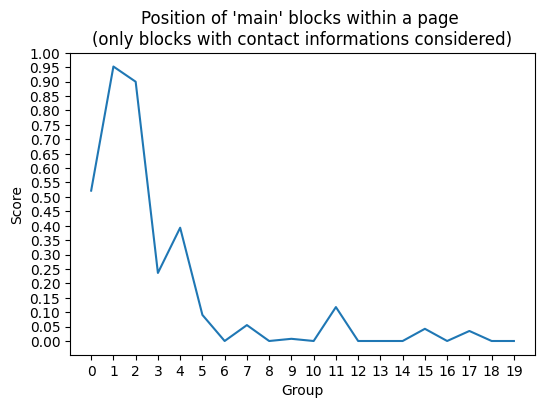

In [323]:
fig = plt.figure(dpi=100)
pd.DataFrame.from_dict(all_naive_scores, orient="index", columns=["score"]).plot(
    title="Position of 'main' blocks within a page \n(only blocks with contact informations considered)",
    xticks=range(0,20),
    yticks=np.arange(0,1.05,0.05),
    xlabel="Group",
    ylabel="Score",
    legend=False,
    ax = plt.gca()
)
fig.savefig("main_blocks_distribution.png", transparent=False, facecolor="white")
plt.show()

## Vectorizing

In [266]:
def get_feature_mtx2(lines, tokenized_lines, **kwargs):
    """ TODO """
    
    # prepare feature collection, run regex_preprocessor
    mtx = []
    feature_names = []
    regex_result = regex_preprocessor.process(lines, keep_line_count=True)

    ### multi-dimensional features ###
    mtx.extend(featurize.embedding_feature(lines))
    feature_names.append("embedding_feature")
    
    mtx.extend(featurize.regex_feature(lines, regex_result["occurrences"]))
    feature_names.append("regex_feature")
    
    mtx.extend(featurize.list_based_feature(tokenized_lines, regex_result))
    feature_names.append("list_based_feature")

    ### 1-dimensional features ###
    mtx.append(featurize.number_of_tokens_feature(tokenized_lines))
    feature_names.append("number_of_tokens")
    
    mtx.append(featurize.number_of_chars_feature(lines))
    feature_names.append("number_of_chars")
    
    mtx.append(featurize.median_token_len_feature(tokenized_lines))
    feature_names.append("median_token_len")
    
    #mtx.append(featurize.linenumber_feature(lines))
    #feature_names.append("linenumber")
    
    for k, v in kwargs.items(): 
        feature_names.append(k)
        mtx.append([v])
    
    # return list of list of features
    return mtx, feature_names

def relative_linenumber_feature():
    return ...

In [267]:
def extract_features(data):
    X = []

    for _, instance in data.iterrows():
        text = instance.lines
        lines = tokenizer.get_lines(text, keep_line_count=True)
        tokens = tokenizer.get_words(text, keep_line_count=True)

        # get feature matrix
        feature_mtx, feature_names = get_feature_mtx2(lines, 
                                                      tokens, 
                                                      relative_indices=instance.relative_indices)
        feature_count = len(feature_mtx)

        # transpose feature matrix
        feature_mtx = list(map(list, zip(*feature_mtx)))

        X.extend(feature_mtx)
    
    y = data.classes
    
    return np.array(X, dtype=np.float32), np.array(y), feature_names

In [268]:
%%time
df = full_df.copy()
#df = short_df.copy()
#df = bi_df.copy()
train, test = train_test_split(df, test_size=0.2, random_state=42)
X_train, y_train, feature_names = extract_features(train)
X_test, y_test, _ = extract_features(test)

CPU times: user 15min 19s, sys: 4.73 s, total: 15min 24s
Wall time: 5min 42s


In [269]:
len(X_train), len(train.classes)

(267900, 267900)

## Training

In [270]:
%%time
clf = LinearSVC()
#clf = DummyClassifier()
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
score = accuracy_score(pred, y_test)
score

/home/jpaulus/miniconda3/envs/data3.9/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


CPU times: user 13min 34s, sys: 771 ms, total: 13min 35s
Wall time: 13min 34s


0.8797927615862399

In [271]:
%%time
clf = DummyClassifier()
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
score = accuracy_score(pred, y_test)
score

CPU times: user 133 ms, sys: 0 ns, total: 133 ms
Wall time: 130 ms


0.8680273530817009

In [272]:
%%time
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
score = accuracy_score(pred, y_test)
score

CPU times: user 3min 33s, sys: 0 ns, total: 3min 33s
Wall time: 3min 33s


0.8585164835164835

In [273]:
dict(zip(feature_names, clf.feature_importances_))

{'embedding_feature': 0.001503071218453315,
 'regex_feature': 0.0012545769679202443,
 'list_based_feature': 0.0016094552358553494,
 'number_of_tokens': 0.001280103259569003,
 'number_of_chars': 0.0012366422493360902,
 'median_token_len': 0.0014697072057908342,
 'relative_indices': 0.0016660255793937927}

In [274]:
%%time
clf = XGBClassifier(use_label_encoder=False, eval_metric="logloss")
y_train_encoded = LabelEncoder().fit_transform(y_train)
y_test_encoded = LabelEncoder().fit_transform(y_test)
clf.fit(X_train, y_train_encoded)
pred = clf.predict(X_test)
score = accuracy_score(pred, y_test_encoded)
score

CPU times: user 1h 9min 42s, sys: 1.11 s, total: 1h 9min 43s
Wall time: 11min 39s


0.9089375298614429

In [275]:
dict(zip(feature_names, clf.feature_importances_))

{'embedding_feature': 0.0010970044,
 'regex_feature': 0.0025507407,
 'list_based_feature': 0.0055626323,
 'number_of_tokens': 0.0016366497,
 'number_of_chars': 0.0019836244,
 'median_token_len': 0.0020008166,
 'relative_indices': 0.004240238}